In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

# Cluster Level

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
cdata = ad.read_h5ad("./RNA/Multitime.fixed.guide.h5")

In [3]:
# on cluster level: mean count to cluster DEGs
l2fc_matrix = np.matrix([list(vec) for vec in fdata.uns["rank_genes_groups"]["logfoldchanges"].tolist()]).T

In [170]:
grouped_sum = fdata.to_df().groupby(fdata.obs['cluster_cellcharter_givenk'], observed=True).sum()
cluster_counts = fdata.obs["cluster_cellcharter_givenk"].value_counts().sort_index()
grouped_mean = np.matrix(grouped_sum.div(cluster_counts, axis=0))

In [172]:
cdata.obs["cluster_cellcharter_givenk"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
guide_cluster_counts = pd.DataFrame(cdata.X)
guide_cluster_counts.columns = cdata.var_names
guide_cluster_counts["cluster"] = cdata.obs["cluster_cellcharter_givenk"].tolist()

guide_total_counts = guide_cluster_counts.sum(axis=0)[:-1]
guide_cluster_proportions = guide_cluster_counts.groupby(["cluster"]).sum()
guide_cluster_proportions = guide_cluster_proportions.div(guide_total_counts, axis=1)
guide_cluster_proportions.index = guide_cluster_proportions.index.astype(int)
guide_cluster_proportions = guide_cluster_proportions.T.reindex(sorted(guide_cluster_proportions.index), axis=1)
for i in range(12): guide_cluster_proportions[i] = guide_cluster_proportions.convert_dtypes().loc[:, i].astype(float).to_list()
guide_matrix = np.matrix(guide_cluster_proportions).T 

In [173]:
rho = spearmanr(np.hstack((guide_matrix, grouped_sum)), axis=0)[0]

In [ ]:
def row_wise_pearson(x, y):
    mean_x = np.mean(x, axis=1, keepdims=True)
    mean_y = np.mean(y, axis=1, keepdims=True)
    x_centered = x - mean_x
    y_centered = y - mean_y
    covariance = np.sum(x_centered * y_centered, axis=1)
    std_x = np.std(x, axis=1)
    std_y = np.std(y, axis=1)
    correlation = covariance / (std_x * std_y * x.shape[1])
    return correlation

In [ ]:
rho = pearsonr()

In [174]:
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+grouped_sum.shape[1]]

In [149]:
np.savetxt("./cluster.spearmanr.txt", corr_matrix, fmt="%6f")

In [63]:
corr_matrix = np.loadtxt("./cluster.spearmanr.txt")

In [175]:
high_correlated_gene = []
low_correlated_gene = []
for i in range(34):
    guide_vec = corr_matrix[i]
    mu = np.mean(guide_vec)
    std = np.std(guide_vec)
    z = (guide_vec - mu) / std

    high_correlated = (z > np.quantile(z, 0.999))
    low_correlated = (z < np.quantile(z, 0.001))
    high_correlated_gene += (fdata.var_names[high_correlated].tolist())
    low_correlated_gene += (fdata.var_names[low_correlated].tolist())
high_correlated_gene = set(high_correlated_gene)
low_correlated_gene = set(low_correlated_gene)
print("high:", len(high_correlated_gene), ", low:", len(low_correlated_gene))

high: 117 , low: 55


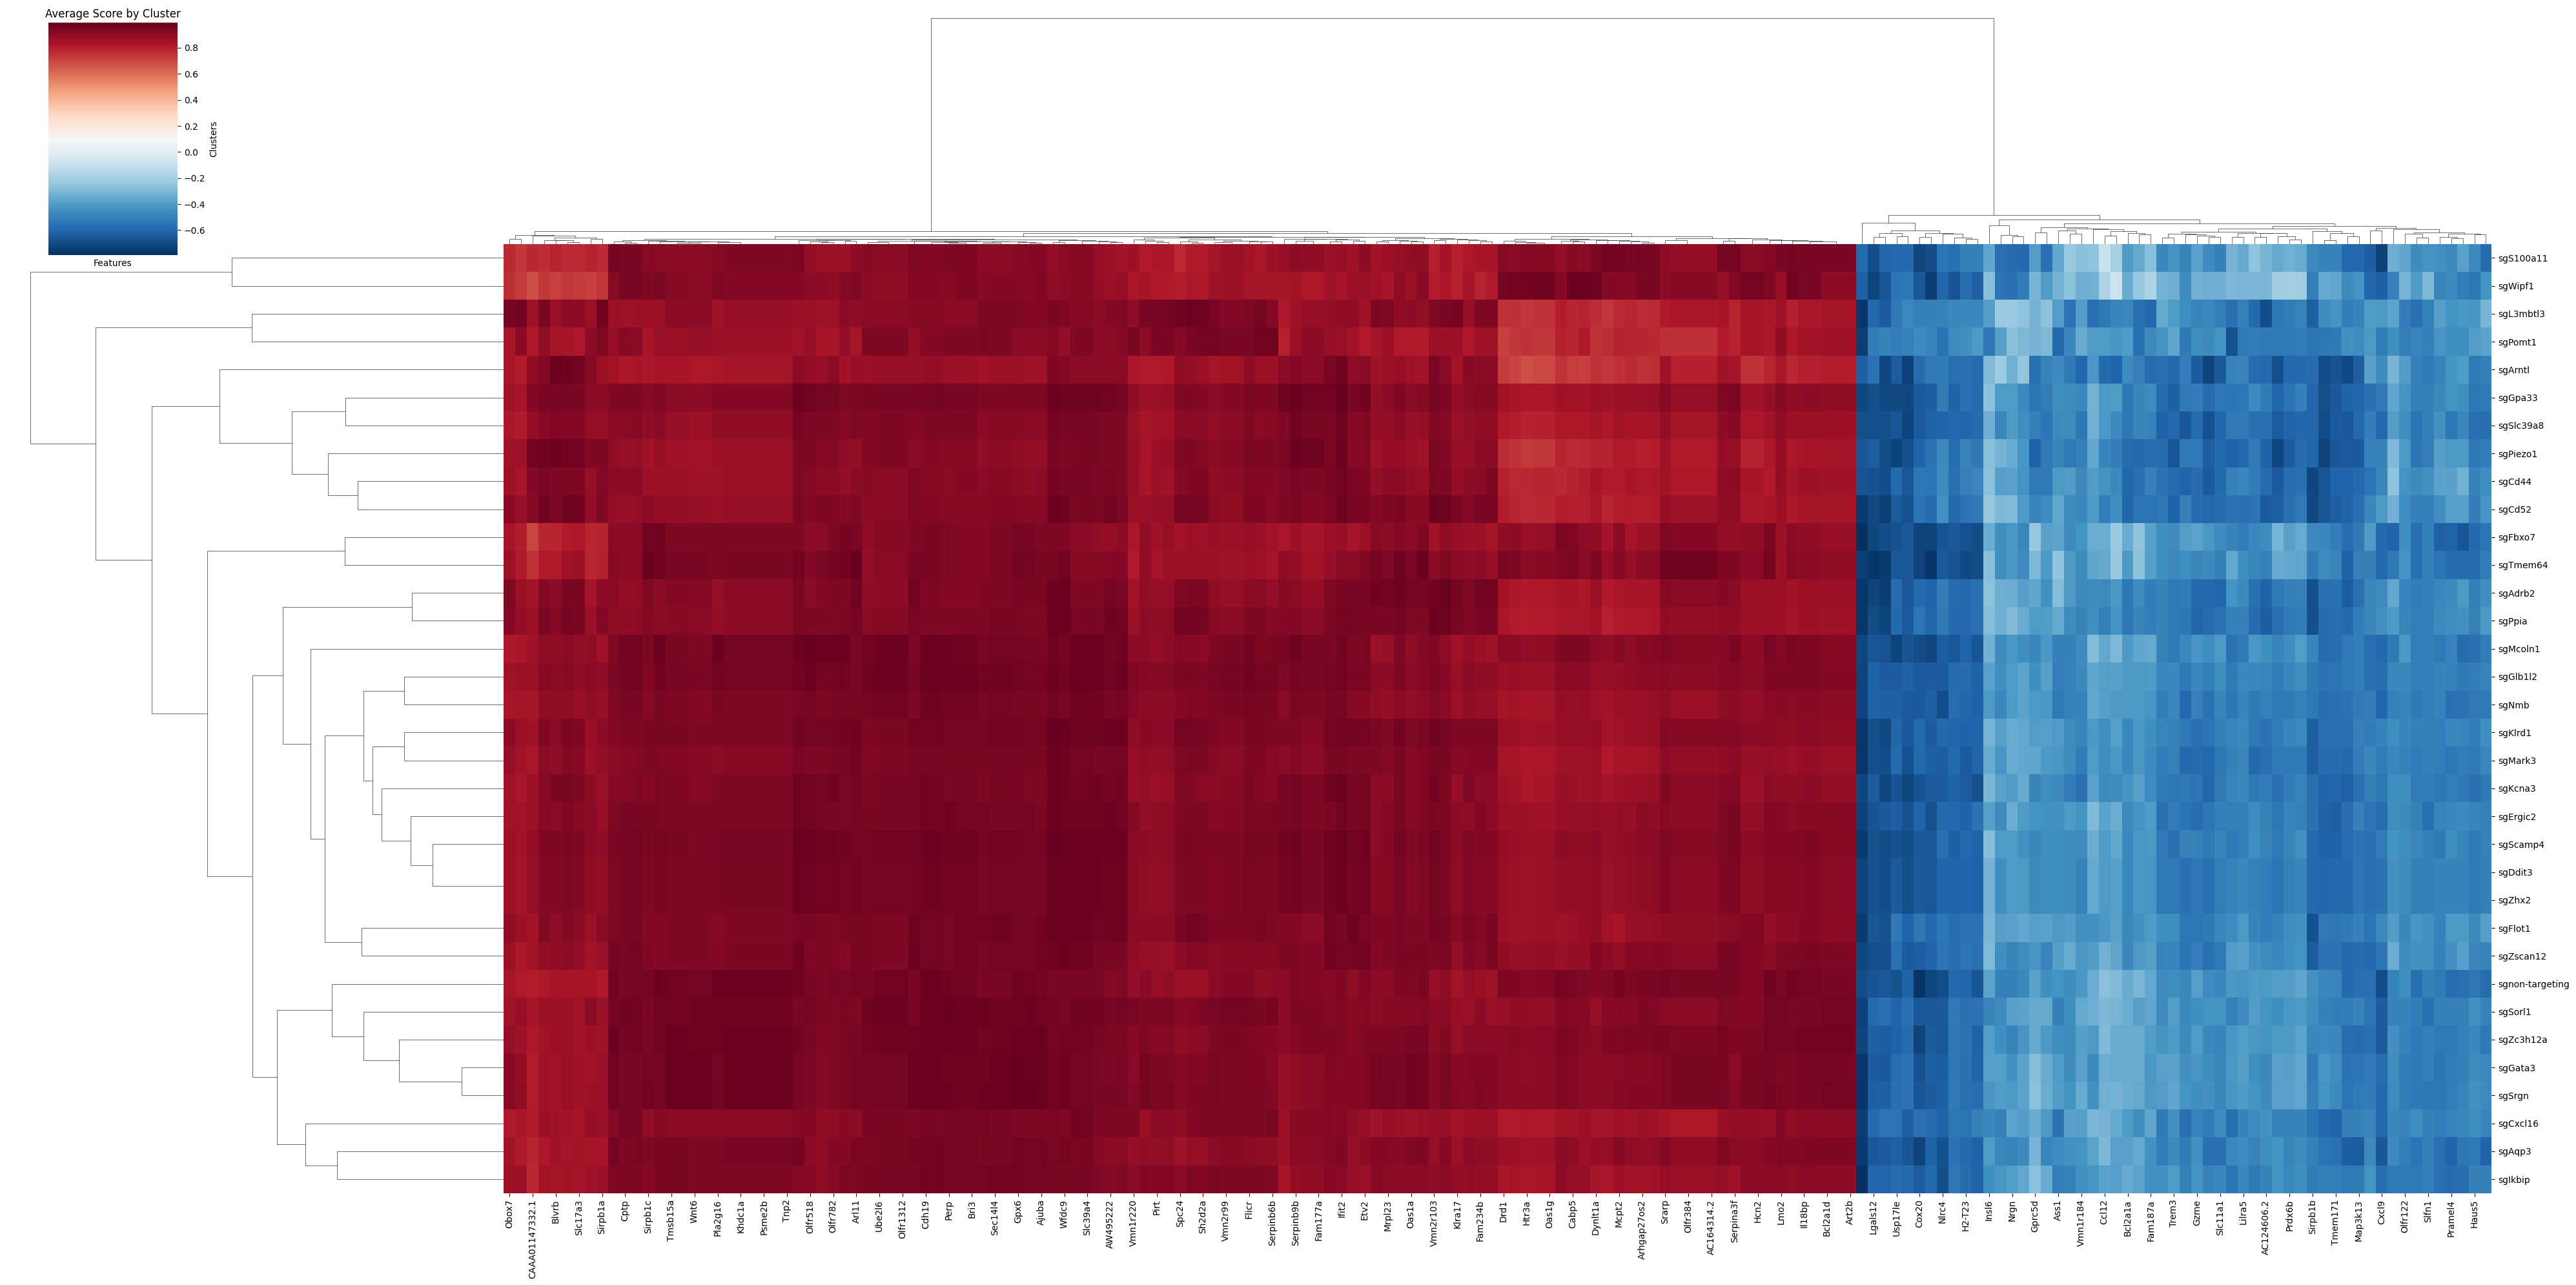

In [176]:
interest_gene = high_correlated_gene.union(low_correlated_gene)
interest_matrix = corr_matrix[:, np.isin(fdata.var_names, list(interest_gene))]
interest_df = pd.DataFrame(interest_matrix)
interest_df.index = cdata.var_names
interest_df.columns = list(interest_gene)

sns.clustermap(interest_df, annot=False, fmt=".2f", cmap="RdBu_r", figsize=(40, 20))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Bin Level

In [27]:
# on bin level: count to all genes
guide_matrix = cdata.X
for ig in range(guide_matrix.shape[1]):
    guide_matrix[:, ig] = guide_matrix[:, ig] / np.sum(guide_matrix[:, ig])
corr_matrix = np.zeros((guide_matrix.shape[1], len(fdata.var_names)))
for idx, var in tqdm(enumerate(fdata.var_names)):
    expr_vec = fdata[:, var].X.toarray().flatten()
    for i in range(34):
        corr_matrix[i, idx] = spearmanr(expr_vec, guide_matrix[:, i])[0]

16001it [1:41:20,  2.63it/s]


In [164]:
cluster_deg = top_genes_df[top_genes_df["cluster"] == "5"]["Gene"]
guide_matrix = cdata.X
expr_matrix = fdata[:, cluster_deg].X.toarray()

In [165]:
rho = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)[0]

In [166]:
rho = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)[0]
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]

In [167]:
corr_matrix.shape

(34, 500)

In [141]:
np.savetxt("./spearmanr.txt", corr_matrix, fmt="%6f")

In [4]:
corr_matrix = np.loadtxt("./spearmanr.txt")

In [168]:
np.sum(corr_matrix)

95.96600353084959

In [9]:
high_correlated_gene = []
low_correlated_gene = []
for i in range(34):
    guide_vec = corr_matrix[i]
    mu = np.mean(guide_vec)
    std = np.std(guide_vec)
    z = (guide_vec - mu) / std

    high_correlated = (z > np.quantile(z, 0.999))
    low_correlated = (z < np.quantile(z, 0.001))
    high_correlated_gene += (fdata.var_names[high_correlated].tolist())
    low_correlated_gene += (fdata.var_names[low_correlated].tolist())
high_correlated_gene = set(high_correlated_gene)
low_correlated_gene = set(low_correlated_gene)
print("high:", len(high_correlated_gene), ", low:", len(low_correlated_gene))

high: 57 , low: 52


In [10]:
interest_gene = high_correlated_gene.union(low_correlated_gene)
interest_matrix = corr_matrix[:, np.isin(fdata.var_names, list(interest_gene))]
interest_df = pd.DataFrame(interest_matrix)
interest_df.index = cdata.var_names
interest_df.columns = list(interest_gene)

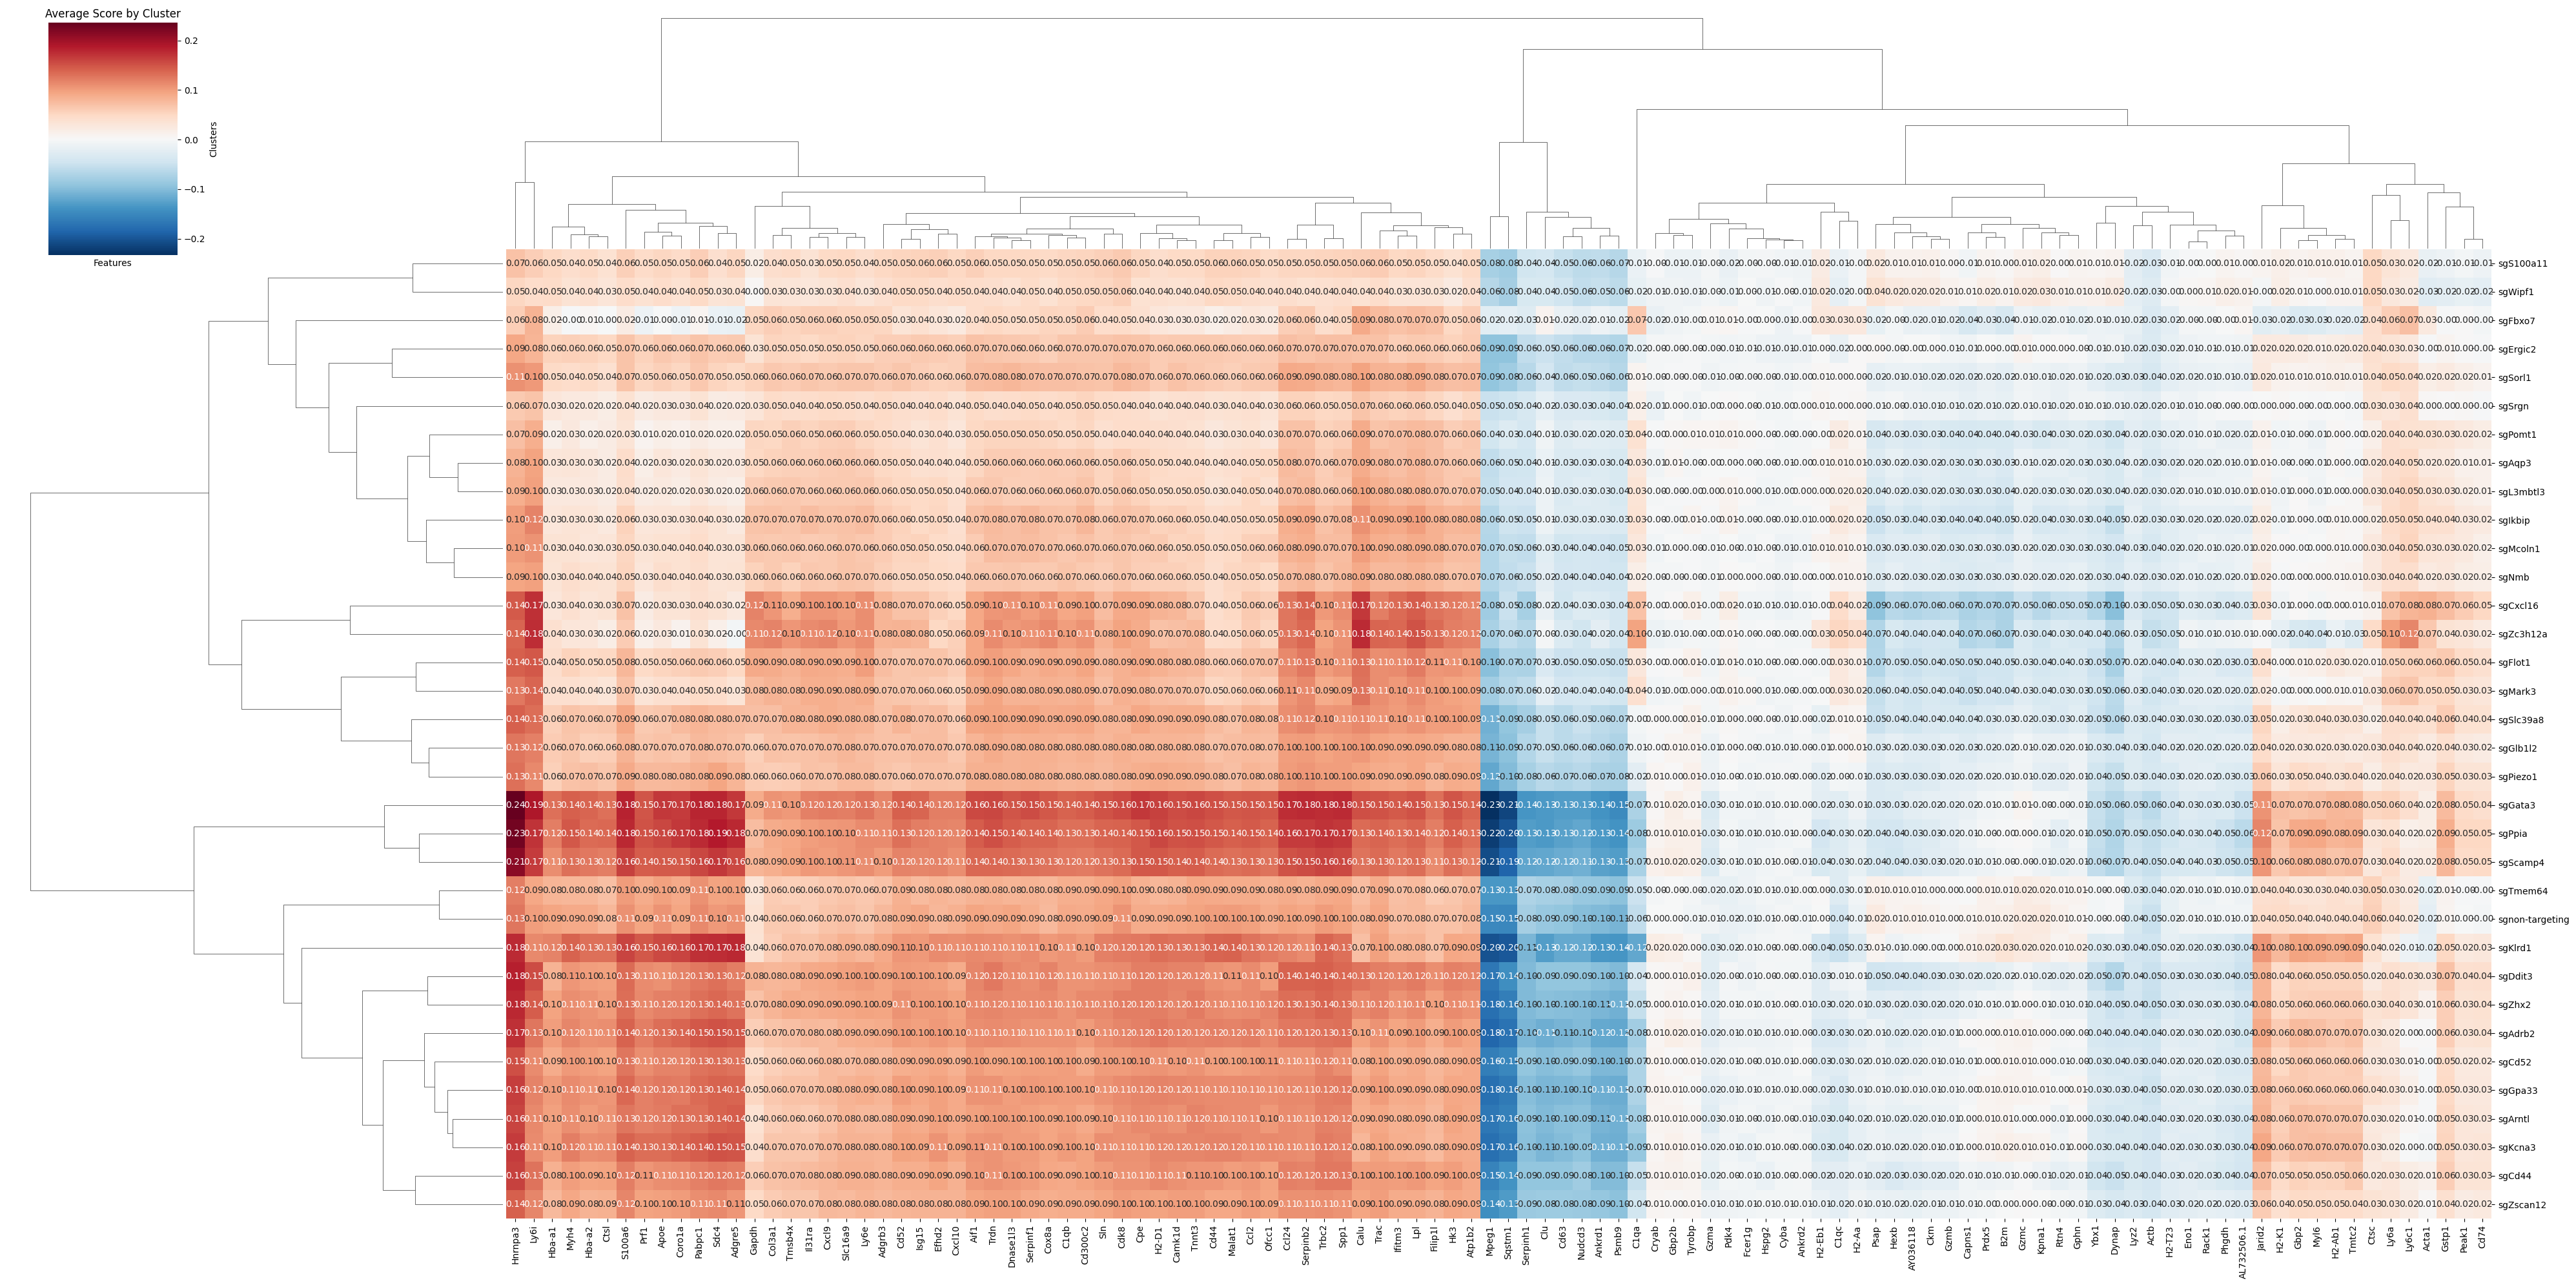

In [11]:
g = sns.clustermap(interest_df, annot=True, fmt=".2f", cmap="RdBu_r", figsize=(40, 20))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

In [134]:
col_linkage = g.dendrogram_col.linkage
col_clusters = fcluster(col_linkage, 0.35, criterion="distance")
col_cluster_df = pd.DataFrame({
    'Gene': interest_df.columns,
    'Cluster': col_clusters
})
col_cluster_df.to_csv('DEG.csv', index=False, sep="\t")
np.unique(col_cluster_df["Cluster"])

array([1, 2, 3, 4, 5], dtype=int32)

In [140]:
col_cluster_df[col_cluster_df["Cluster"] == 5]

Gene  Cluster
3  Cxcl10        5

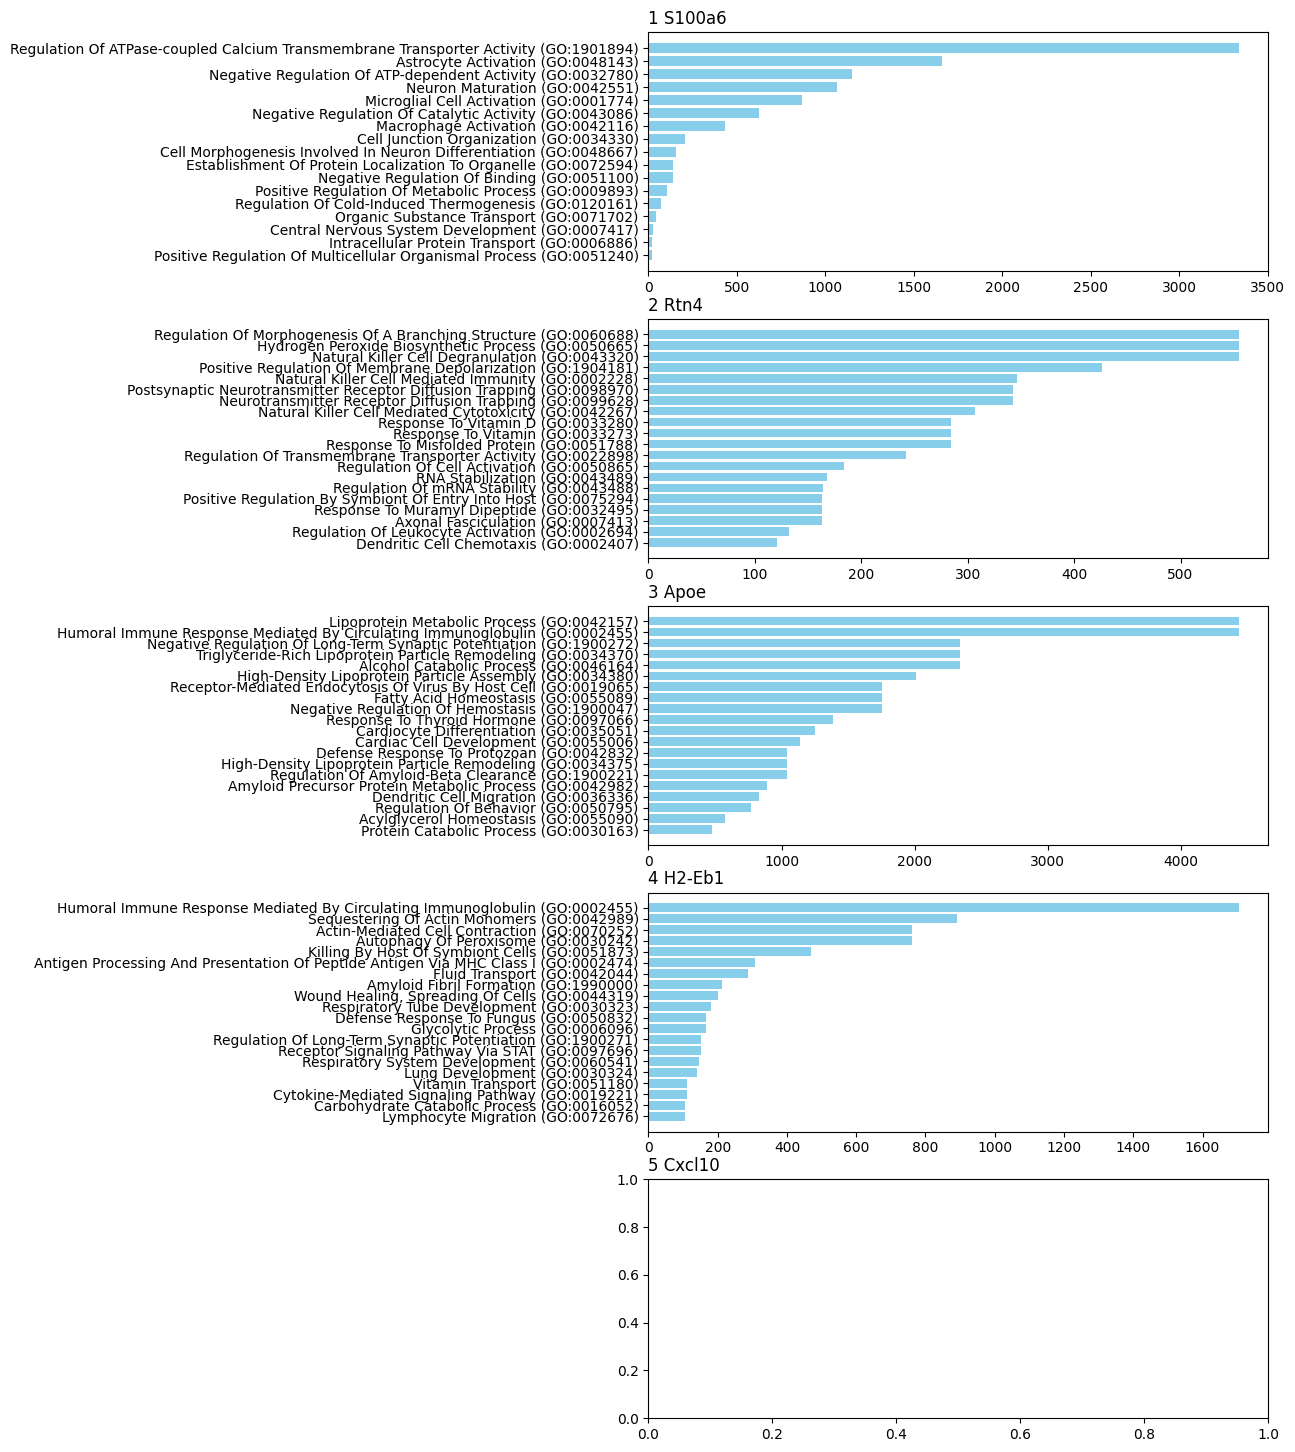

In [141]:
clusters = np.unique(col_cluster_df["Cluster"])
cluster_size = len(clusters)
fig = plt.figure(figsize=(8, 18))
for i in range(cluster_size):
    ax = plt.subplot(cluster_size, 1, i+1)
    plt.title(f"{clusters[i]}" + " " + f"{col_cluster_df[col_cluster_df["Cluster"] == clusters[i]].loc[:,"Gene"].iloc[0]}", loc="left")
    if i == 4: continue
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False).head(20)

    ax.barh(results['Term'], results['Combined Score'], color='skyblue')

    plt.gca().invert_yaxis()

# DEG bin

In [ ]:
cluster_deg = top_genes_df[top_genes_df["cluster"] == "5"]["Gene"]
guide_matrix = cdata.X
expr_matrix = fdata[:, cluster_deg].X.toarray()

In [ ]:
rho = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)[0]
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


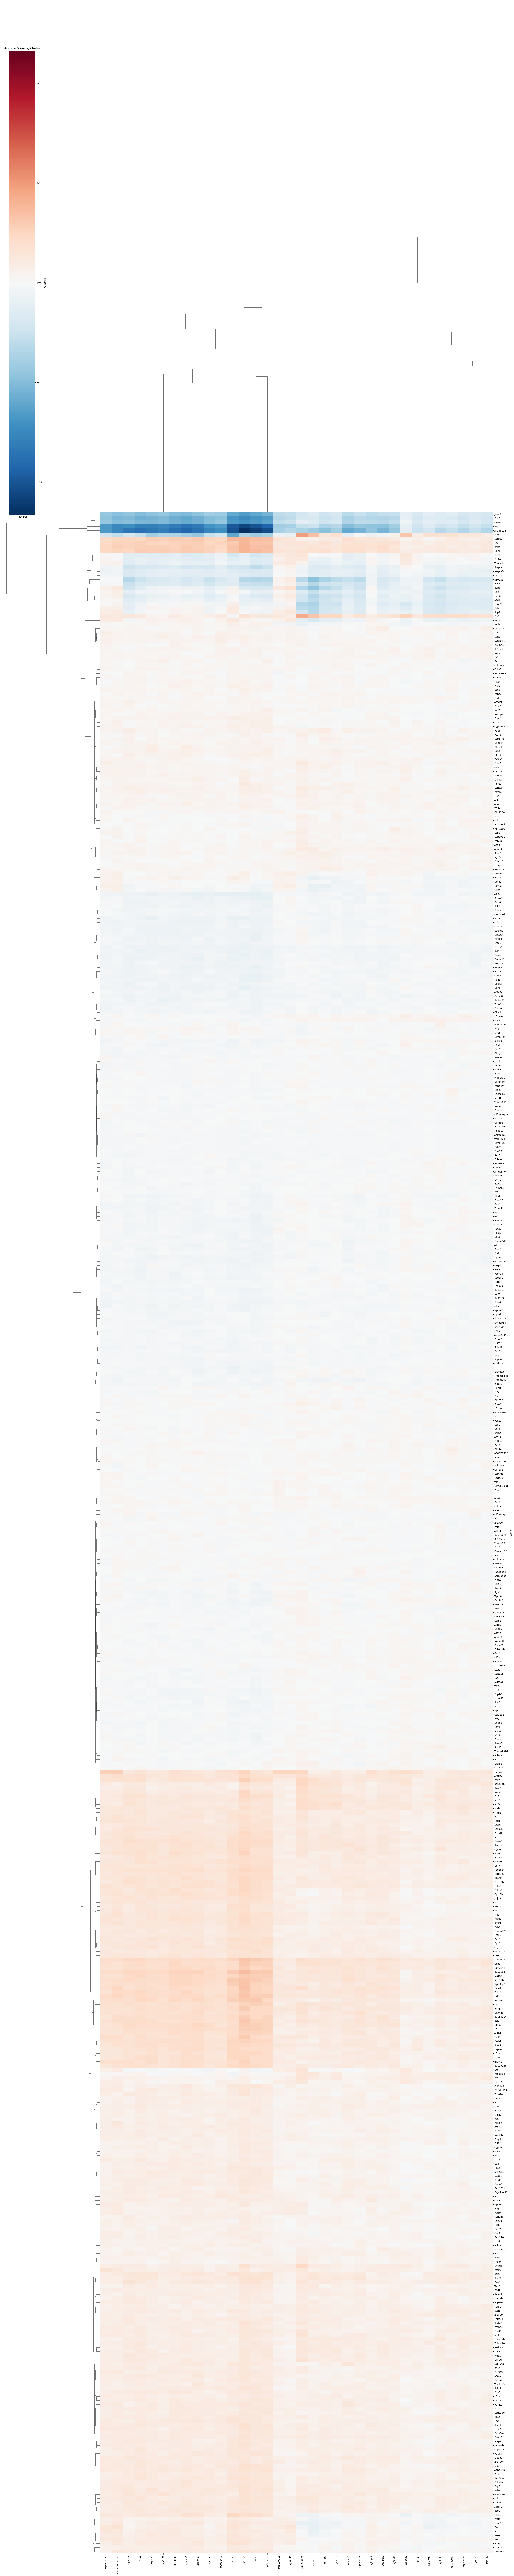

In [169]:
corr_df = pd.DataFrame(corr_matrix[:, ~np.isnan(corr_matrix[0])], columns=cluster_deg[~np.isnan(corr_matrix[0])], index=cdata.var_names)
g = sns.clustermap(corr_df.T, annot=False, fmt="", cmap="RdBu_r", figsize=(30, 150), norm=mcolors.CenteredNorm(vcenter=0.0))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# DEG

In [157]:
pval_cutoff = 0.01
top_n = 500

result = fdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'cluster': group
    })
    
    filtered_data = data[data['padj'] < 0.01]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

Gene  Log2FoldChange          padj      score cluster
0       S100a6        0.705705  0.000000e+00  88.272202       0
1         Spp1        1.079456  0.000000e+00  72.598366       0
2        H2-D1        0.454569  0.000000e+00  69.911057       0
3       Pabpc1        0.957705  0.000000e+00  69.342979       0
4        Krt18        1.343269  0.000000e+00  66.212166       0
...        ...             ...           ...        ...     ...
5995     Myl6b        2.734031  1.375100e-65  17.460184      11
5996  Atp6v0e2        2.805928  2.658820e-65  17.421448      11
5997      Chl1        1.355111  2.680902e-65  17.409033      11
5998      Cobl        2.503455  4.236862e-65  17.391464      11
5999      Cib2        2.473264  5.034946e-65  17.381117      11

[6000 rows x 5 columns]

In [104]:
guide_matrix = cdata.X
expr_matrix = fdata[:, deg].X.toarray()

rho = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)[0]
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]

corr_matrix.shape

(34, 3352)

In [107]:
high_correlated_gene = []
low_correlated_gene = []
for i in range(34):
    guide_vec = corr_matrix[i]
    mu = np.mean(guide_vec)
    std = np.std(guide_vec)
    z = (guide_vec - mu) / std

    high_correlated = (z > np.quantile(z, 0.99))
    low_correlated = (z < np.quantile(z, 0.01))
    high_correlated_gene += (fdata[:, deg].var_names[high_correlated].tolist())
    low_correlated_gene += (fdata[:, deg].var_names[low_correlated].tolist())
high_correlated_gene = set(high_correlated_gene)
low_correlated_gene = set(low_correlated_gene)
print("high:", len(high_correlated_gene), ", low:", len(low_correlated_gene))

high: 117 , low: 156


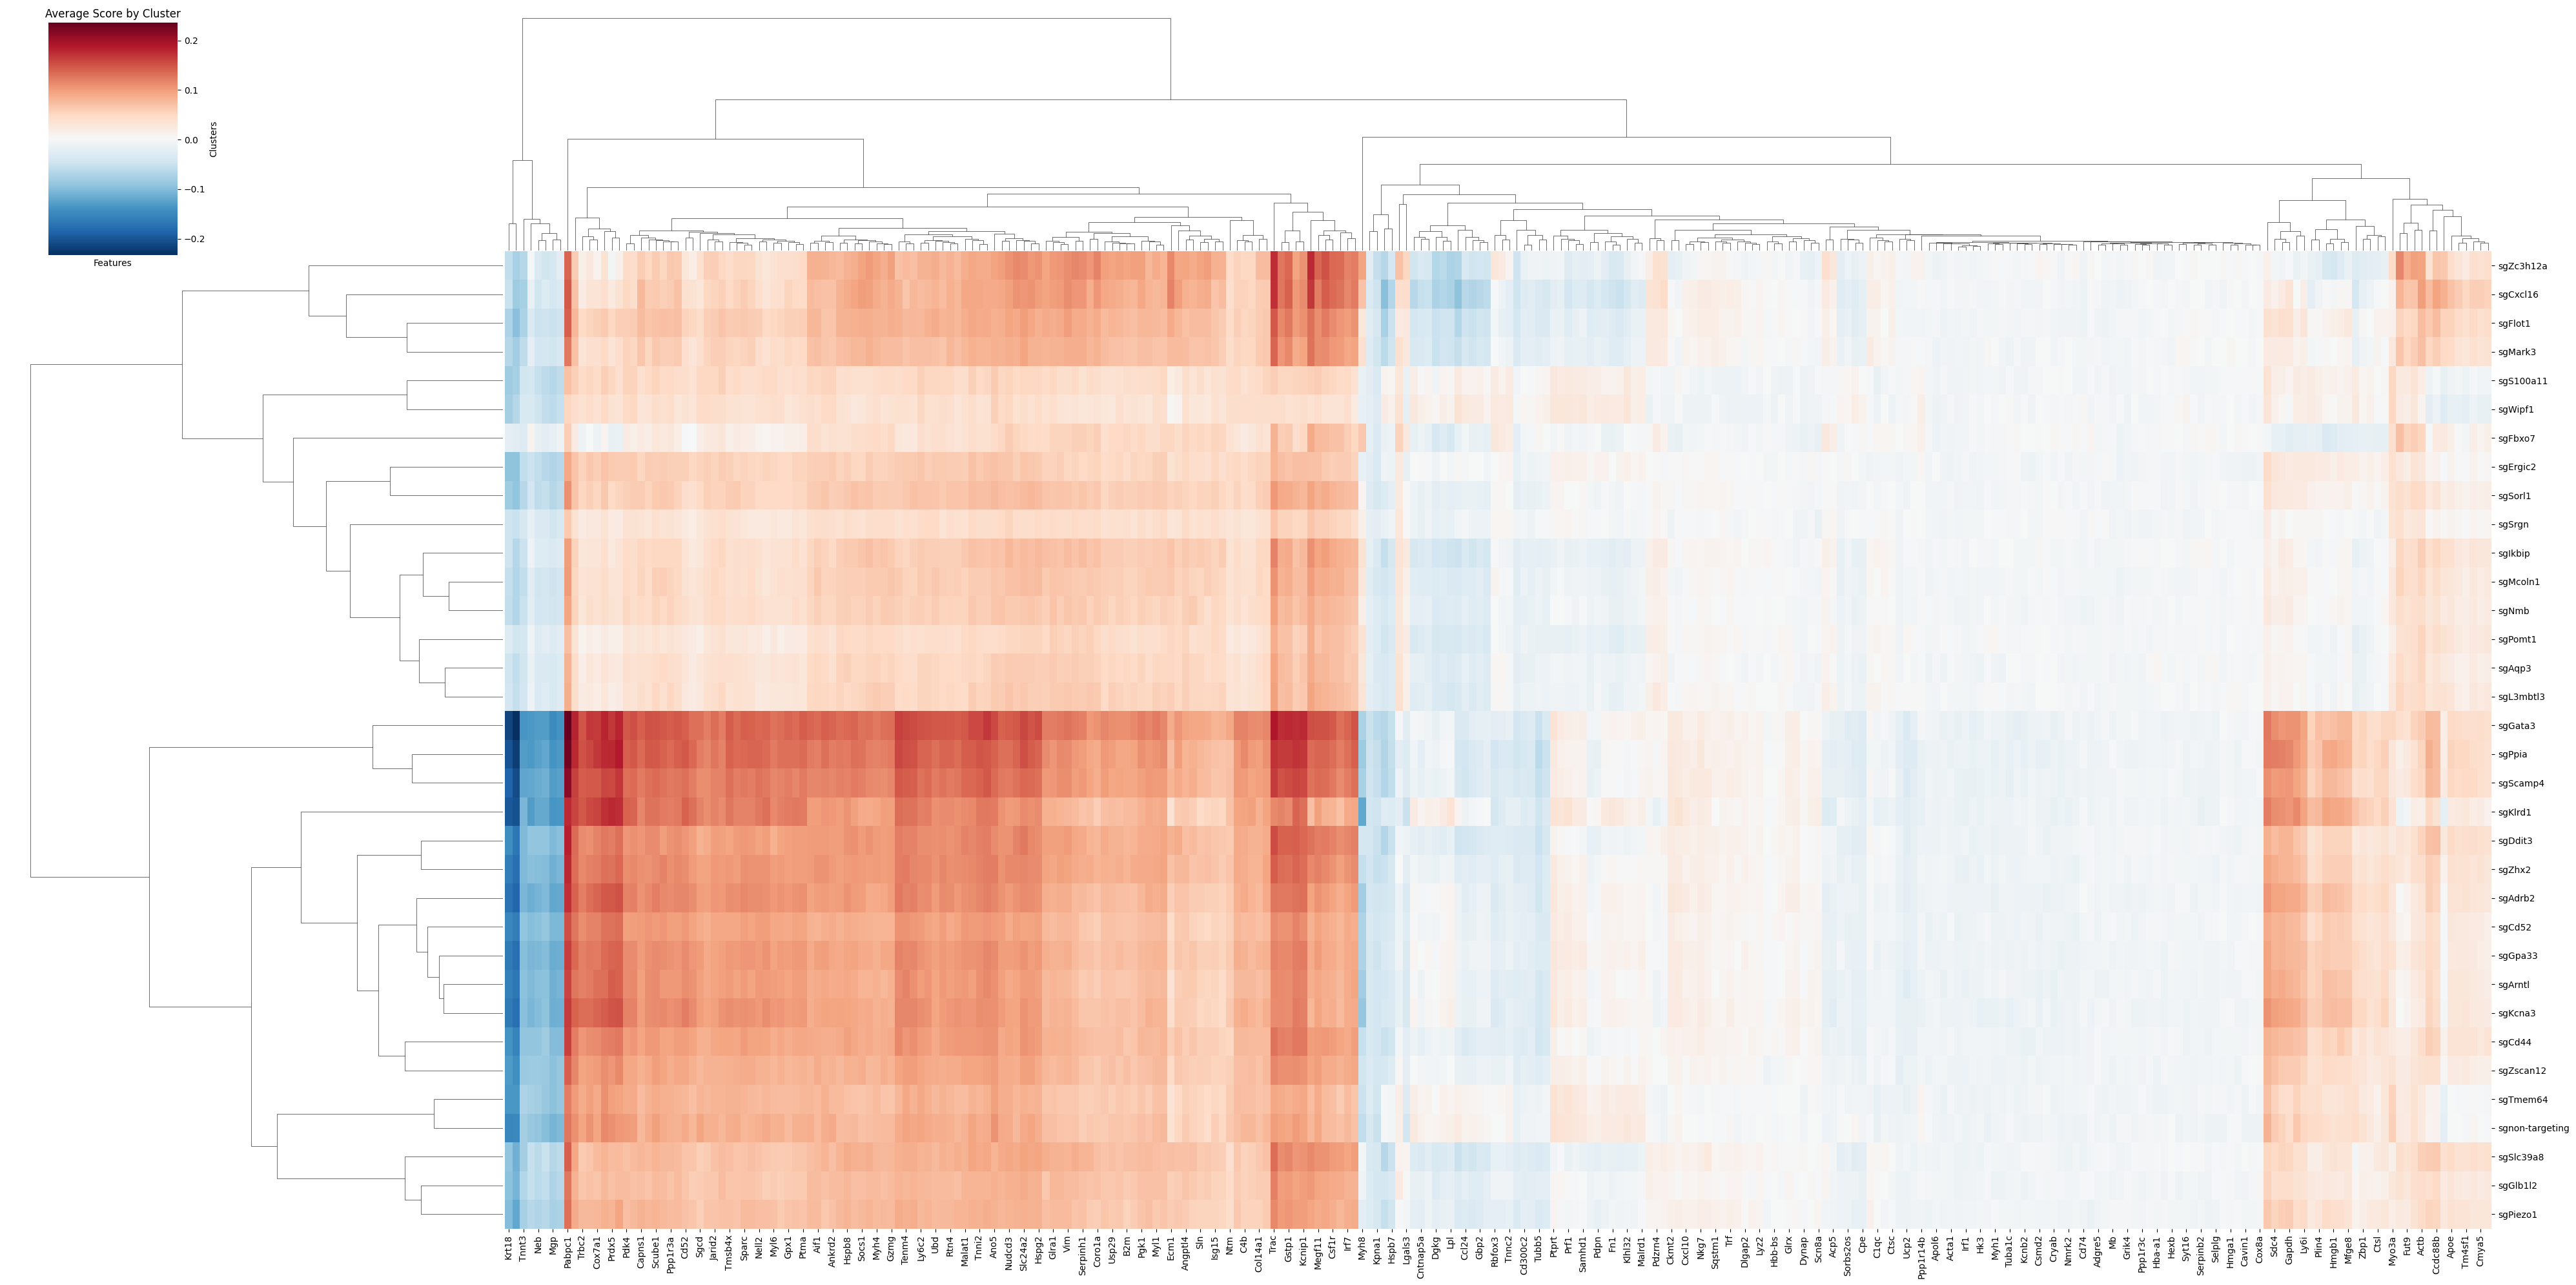

In [72]:
interest_gene = high_correlated_gene.union(low_correlated_gene)
interest_matrix = corr_matrix[:, np.isin(fdata[:, deg].var_names, list(interest_gene))]
interest_df = pd.DataFrame(interest_matrix)
interest_df.index = cdata.var_names
interest_df.columns = list(interest_gene)

g = sns.clustermap(interest_df, annot=False, fmt="", cmap="RdBu_r", figsize=(40, 20))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

In [113]:
col_linkage = g.dendrogram_col.linkage
col_clusters = fcluster(col_linkage, 0.22, criterion="distance")
col_cluster_df = pd.DataFrame({
    'Gene': interest_df.columns,
    'Cluster': col_clusters
})
col_cluster_df.to_csv('DEG.csv', index=False, sep="\t")
np.unique(col_cluster_df["Cluster"])

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [114]:
col_cluster_df[col_cluster_df["Cluster"] == 5]

Gene  Cluster
0       Asic2        5
1       Gbp2b        5
3       Ccl24        5
4        Psap        5
5        Rac2        5
..        ...      ...
252       Dmd        5
253      Ncf1        5
264      Acp5        5
265     Actc1        5
269  Zmiz1os1        5

[122 rows x 2 columns]

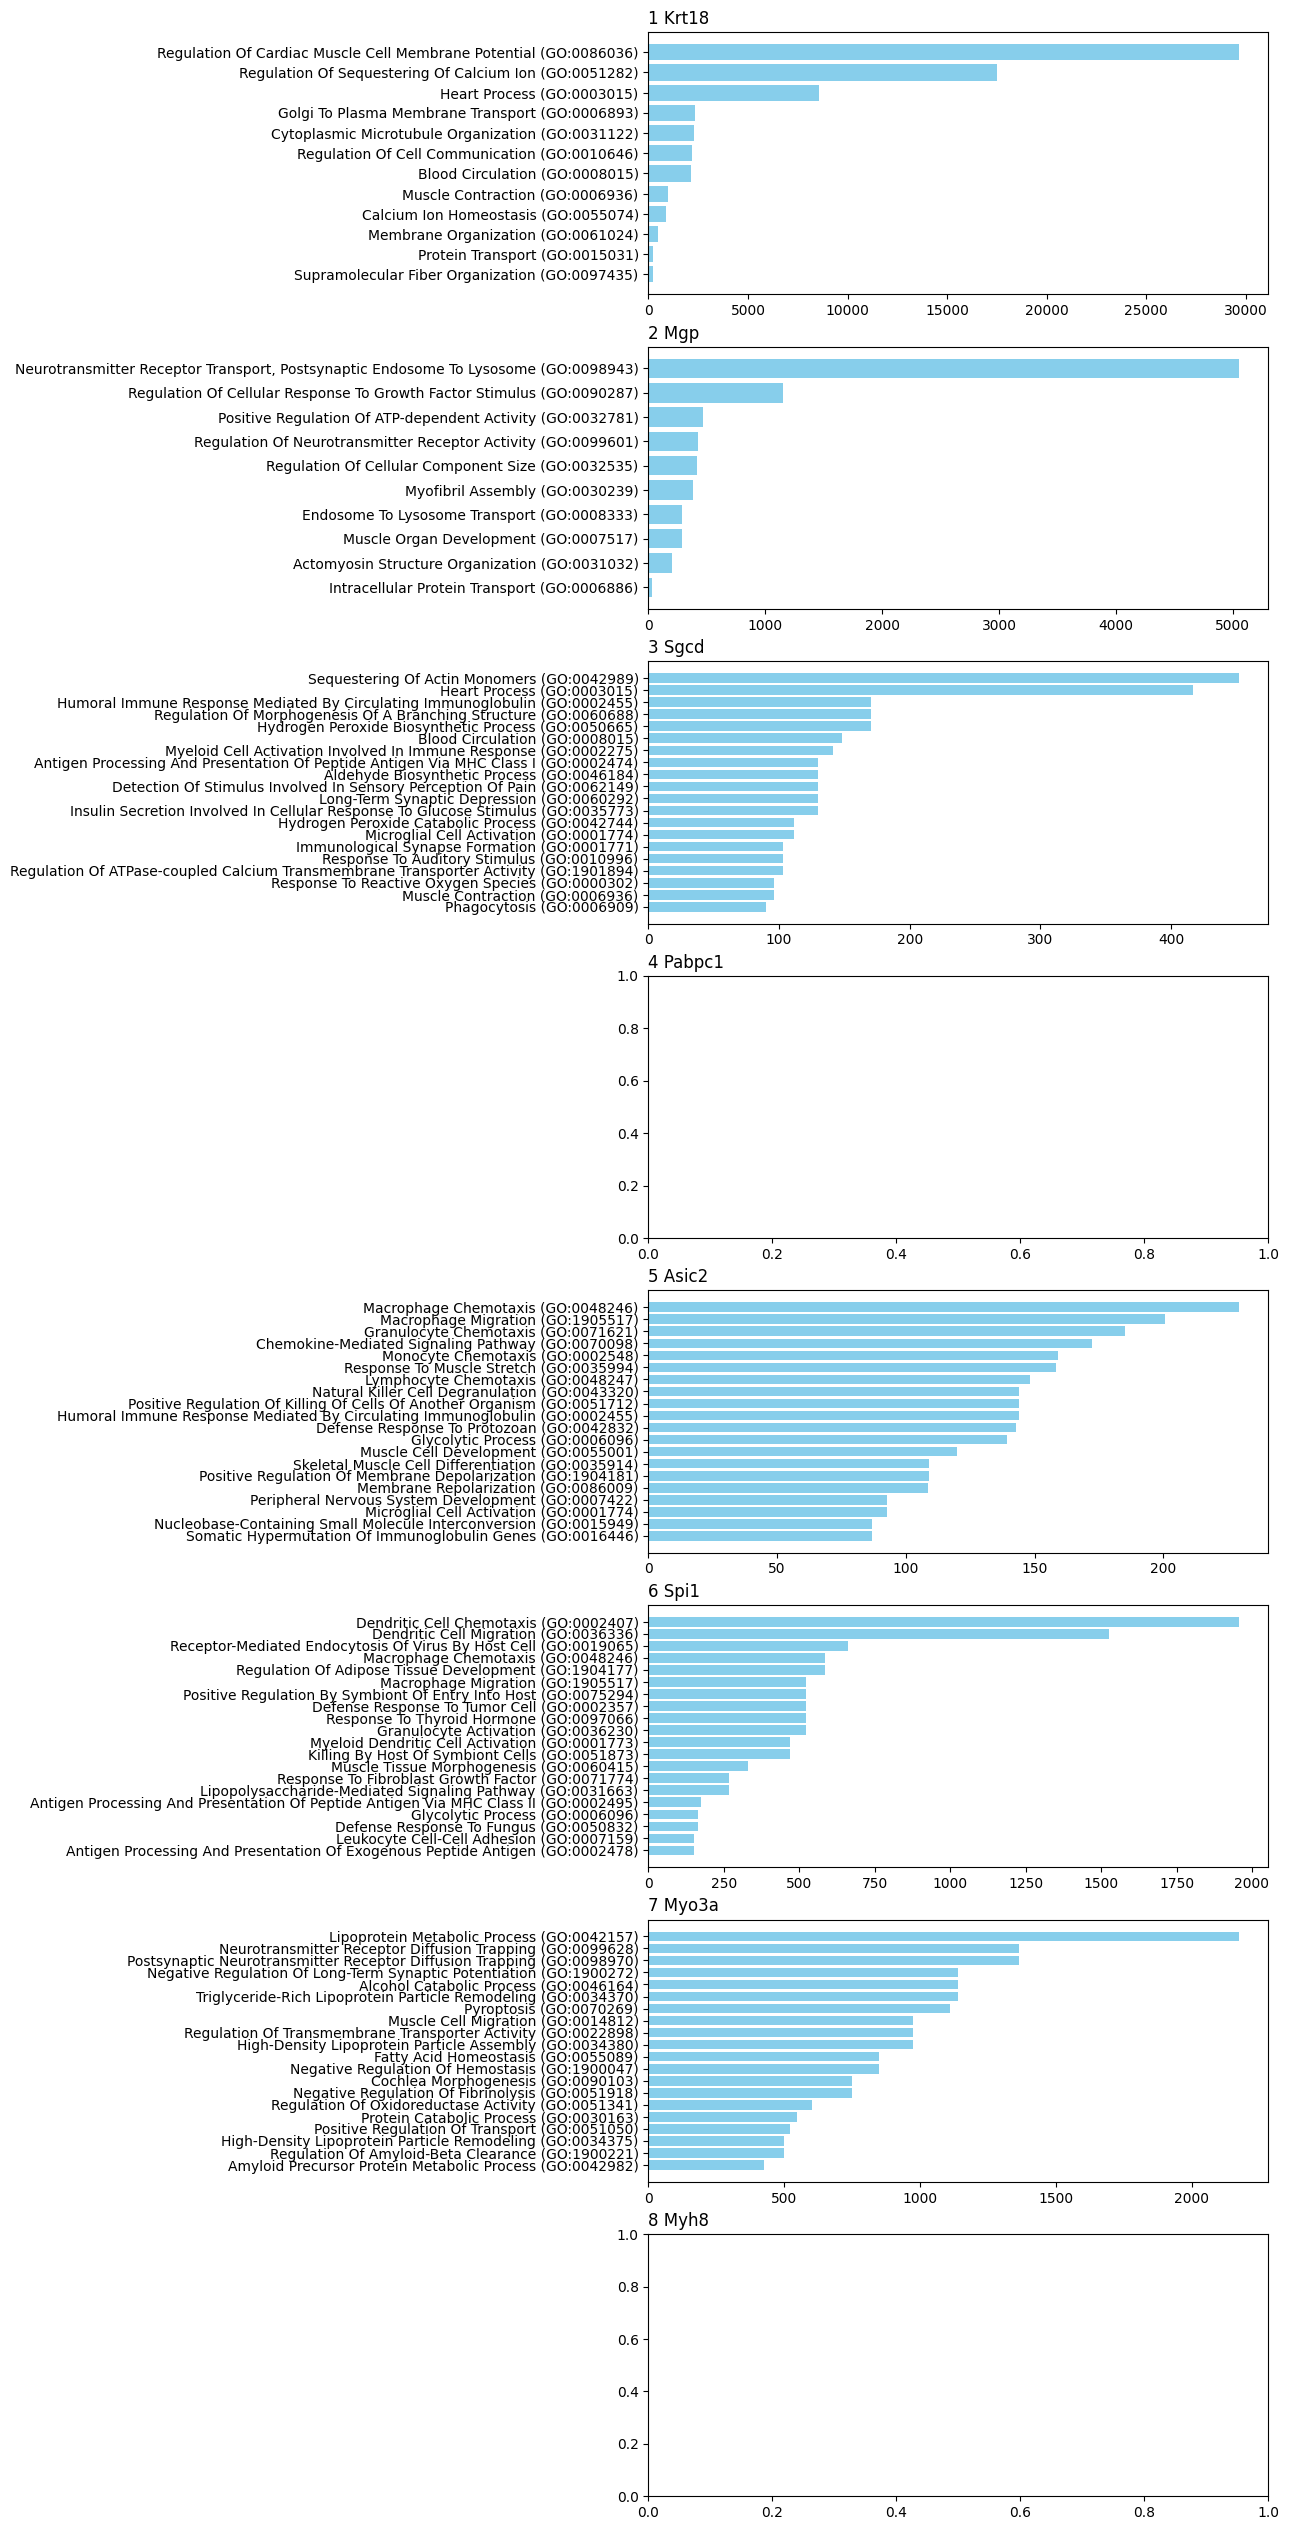

In [116]:
clusters = np.unique(col_cluster_df["Cluster"])
fig = plt.figure(figsize=(8, 32))
for i in range(8):
    ax = plt.subplot(8, 1, i+1)
    plt.title(f"{clusters[i]}" + " " + f"{col_cluster_df[col_cluster_df["Cluster"] == clusters[i]].loc[:,"Gene"].iloc[0]}", loc="left")
    if i == 3 or i == 7: continue
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False).head(20)

    ax.barh(results['Term'], results['Combined Score'], color='skyblue')

    plt.gca().invert_yaxis()

# Time-Cluster specific

In [4]:
pval_cutoff = 0.01
top_n = 500

result = fdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'cluster': group
    })
    
    filtered_data = data[data['padj'] < 0.01]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

Gene  Log2FoldChange          padj      score cluster
0       S100a6        0.705705  0.000000e+00  88.272202       0
1         Spp1        1.079456  0.000000e+00  72.598366       0
2        H2-D1        0.454569  0.000000e+00  69.911057       0
3       Pabpc1        0.957705  0.000000e+00  69.342979       0
4        Krt18        1.343269  0.000000e+00  66.212166       0
...        ...             ...           ...        ...     ...
5995     Myl6b        2.734031  1.375100e-65  17.460184      11
5996  Atp6v0e2        2.805928  2.658820e-65  17.421448      11
5997      Chl1        1.355111  2.680902e-65  17.409033      11
5998      Cobl        2.503455  4.236862e-65  17.391464      11
5999      Cib2        2.473264  5.034946e-65  17.381117      11

[6000 rows x 5 columns]

In [146]:
time_point = 1
cluster_id = 5
cluster_deg = top_genes_df[top_genes_df["cluster"] == f"{cluster_id}"]["Gene"]

guide_matrix = cdata[(fdata.obs["time_point"] == f"{time_point}") & (fdata.obs["cluster_cellcharter_givenk"] == cluster_id)].X.toarray()
expr_matrix = fdata[(fdata.obs["time_point"] == f"{time_point}") & (fdata.obs["cluster_cellcharter_givenk"] == cluster_id), cluster_deg].X.toarray()

In [147]:
rho = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)[0]
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


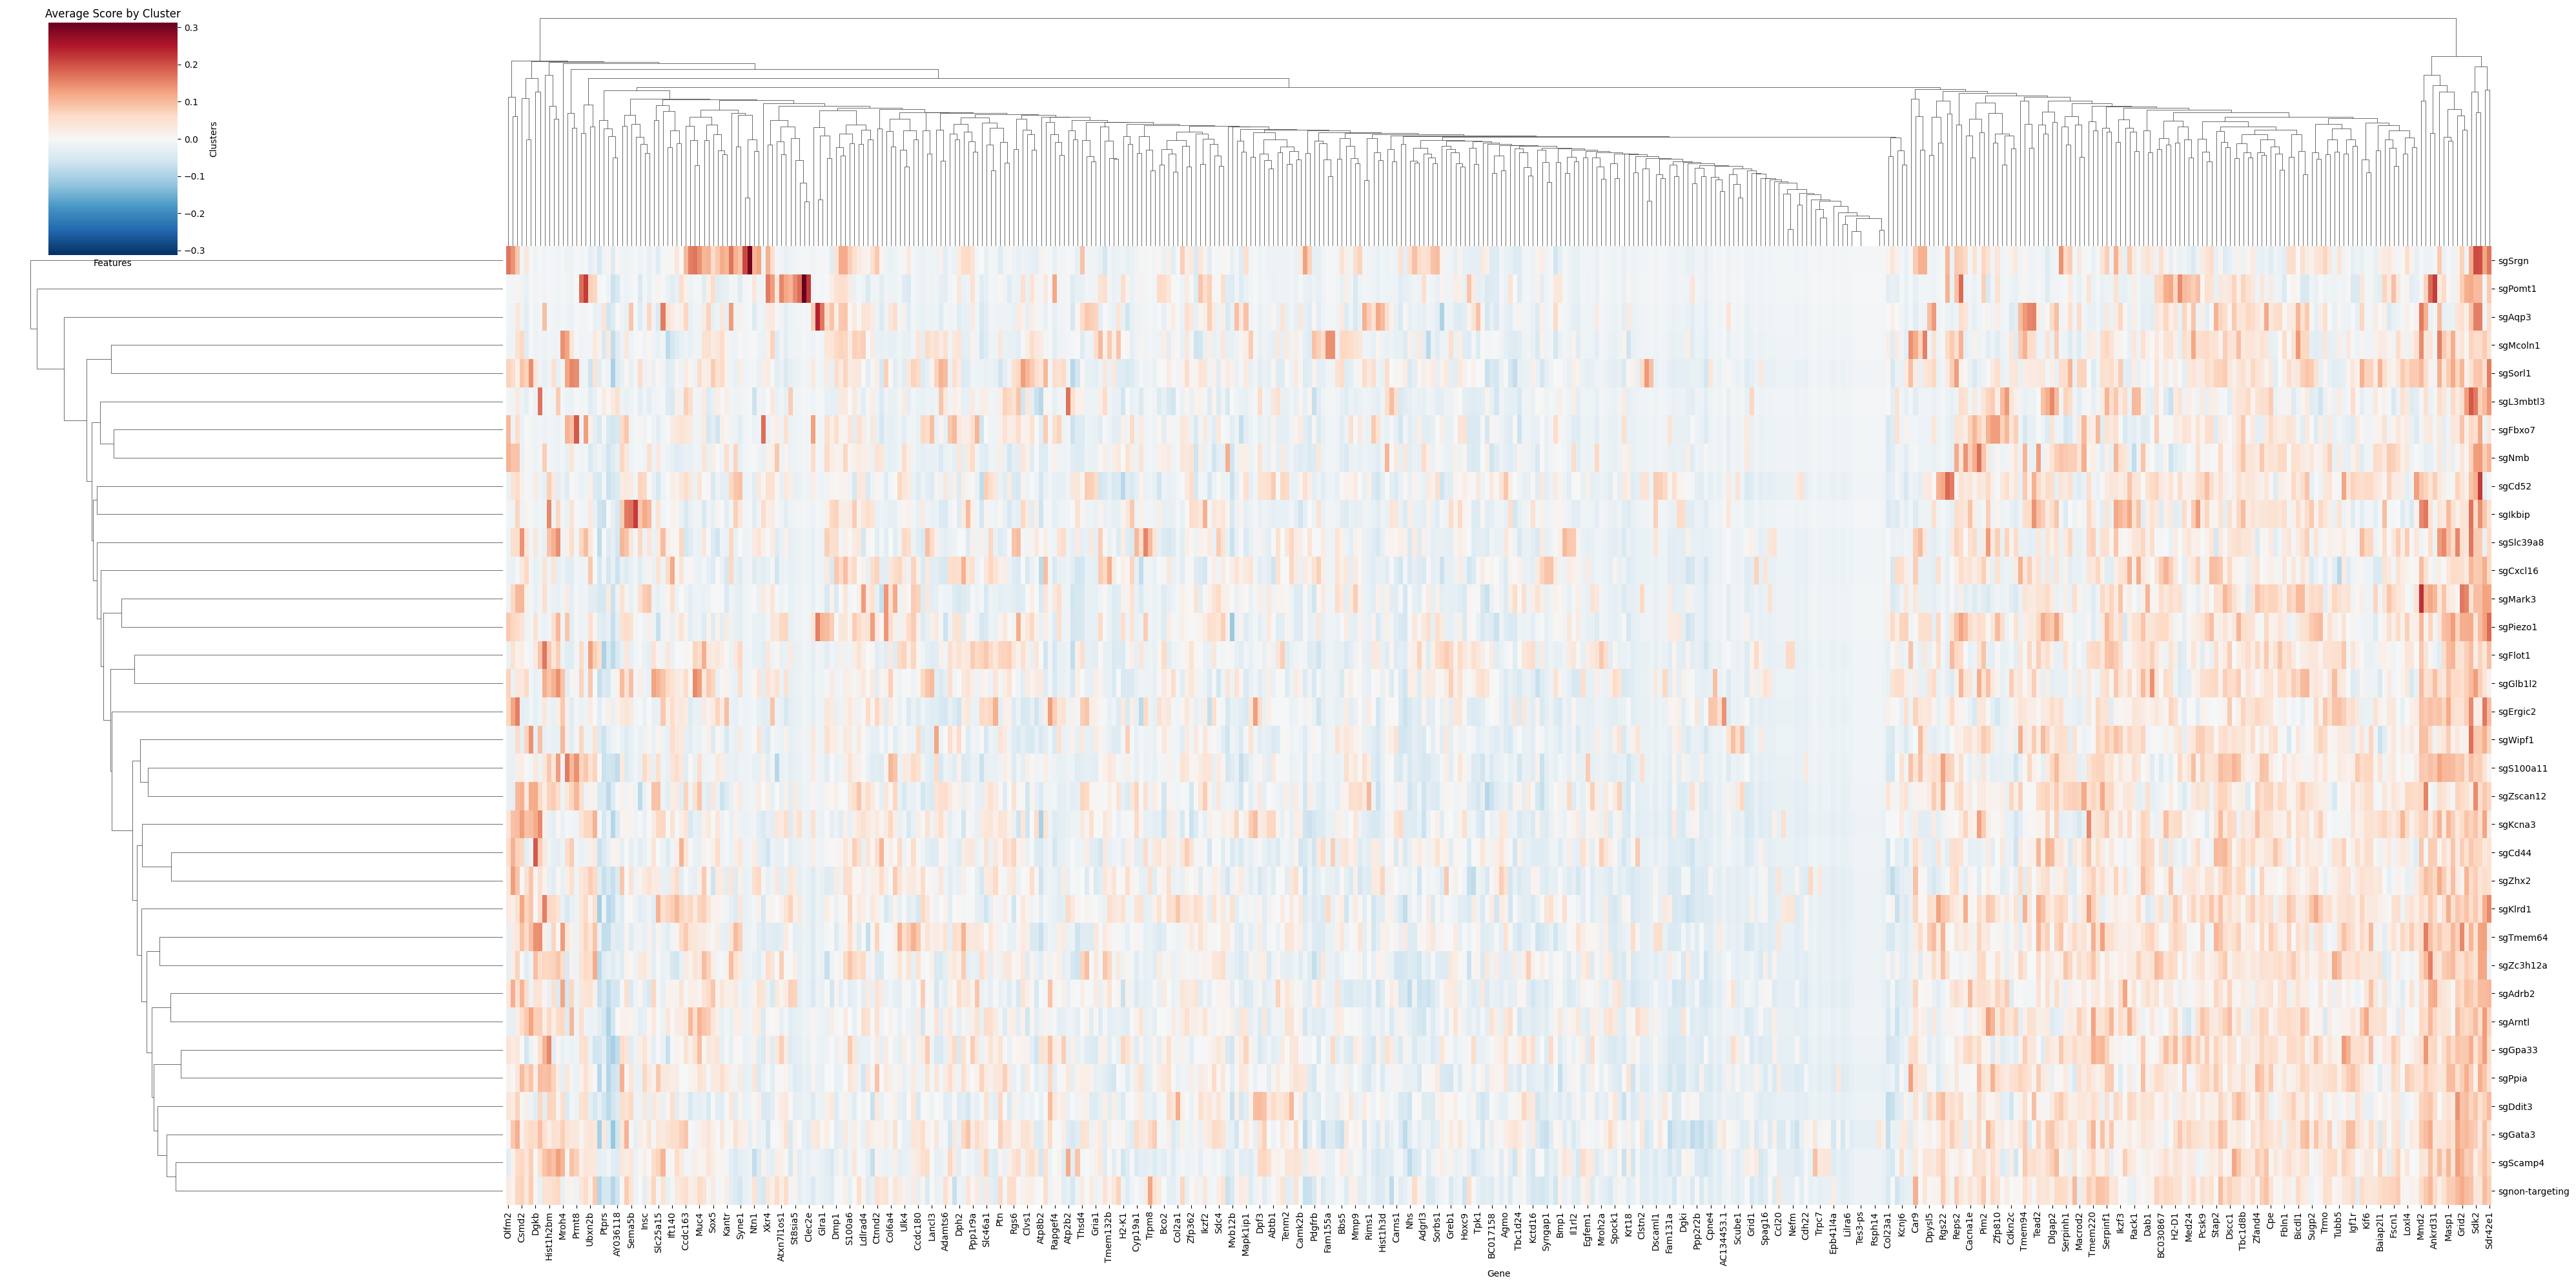

In [148]:
corr_df = pd.DataFrame(corr_matrix[:, ~np.isnan(corr_matrix[0])], columns=cluster_deg[~np.isnan(corr_matrix[0])], index=cdata.var_names)
g = sns.clustermap(corr_df, annot=False, fmt="", cmap="RdBu_r", figsize=(40, 20), norm=mcolors.CenteredNorm(vcenter=0.0))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Cluster specific

In [39]:
# proportion matrix for each gene and cluster
cdata.obs["cluster_cellcharter_givenk"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
guide_cluster_counts = pd.DataFrame(cdata.X)
guide_cluster_counts.columns = cdata.var_names
guide_cluster_counts["cluster"] = cdata.obs["cluster_cellcharter_givenk"].tolist()

guide_total_counts = guide_cluster_counts.sum(axis=0)[:-1]
guide_cluster_proportions = guide_cluster_counts.groupby(["cluster"]).sum()
guide_cluster_proportions = guide_cluster_proportions.div(guide_total_counts, axis=1)
guide_cluster_proportions.index = guide_cluster_proportions.index.astype(int)
guide_cluster_proportions = guide_cluster_proportions.T.reindex(sorted(guide_cluster_proportions.index), axis=1)
for i in range(12): guide_cluster_proportions[i] = guide_cluster_proportions.convert_dtypes().loc[:, i].astype(float).to_list()
ntc_guide_counts = guide_cluster_proportions.iloc[-1]
guide_cluster_proportions = guide_cluster_proportions - ntc_guide_counts

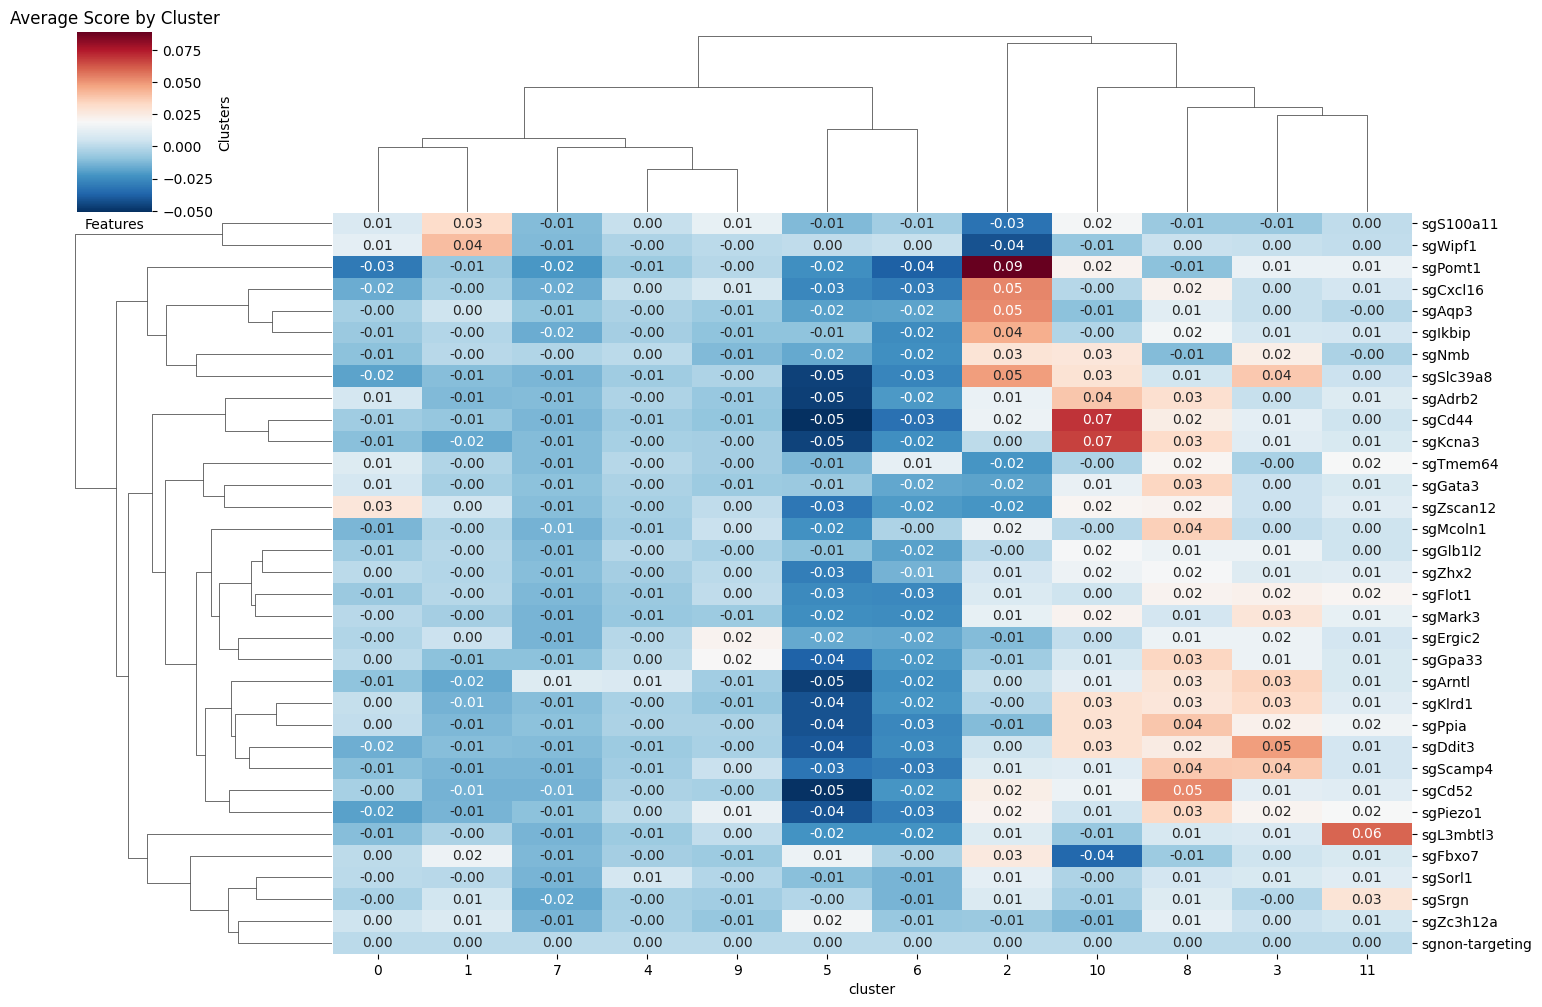

In [40]:
sns.clustermap(guide_cluster_proportions, annot=True, fmt=".2f", cmap="RdBu_r", figsize=(15, 10))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

In [149]:
cluster_id = 7
cluster_deg = top_genes_df[top_genes_df["cluster"] == f"{cluster_id}"]["Gene"]

guide_matrix = cdata[fdata.obs["cluster_cellcharter_givenk"] == cluster_id].X.toarray()
expr_matrix = fdata[fdata.obs["cluster_cellcharter_givenk"] == cluster_id, cluster_deg].X.toarray()

In [150]:
rho, rho_p = spearmanr(np.hstack((guide_matrix, expr_matrix)), axis=0)
corr_matrix = rho[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]
p_matrix = rho_p[:guide_matrix.shape[1], guide_matrix.shape[1]:guide_matrix.shape[1]+expr_matrix.shape[1]]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


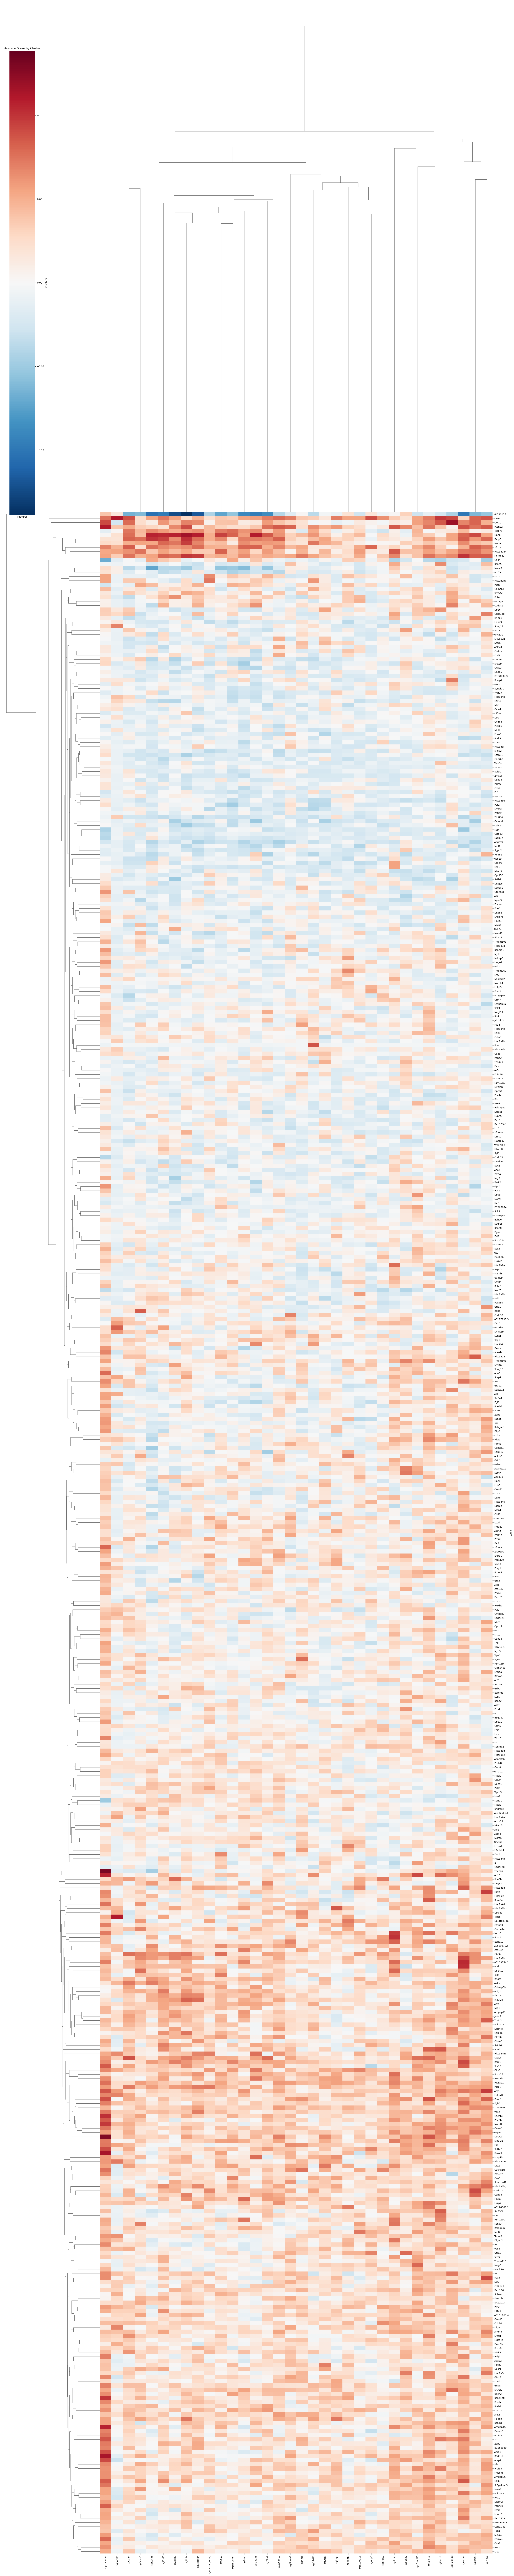

In [151]:
corr_df = pd.DataFrame(corr_matrix[:, ~np.isnan(corr_matrix[0])], columns=cluster_deg[~np.isnan(corr_matrix[0])], index=cdata.var_names)
g = sns.clustermap(corr_df.T, annot=False, fmt="", cmap="RdBu_r", figsize=(30, 150), norm=mcolors.CenteredNorm(vcenter=0.0))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

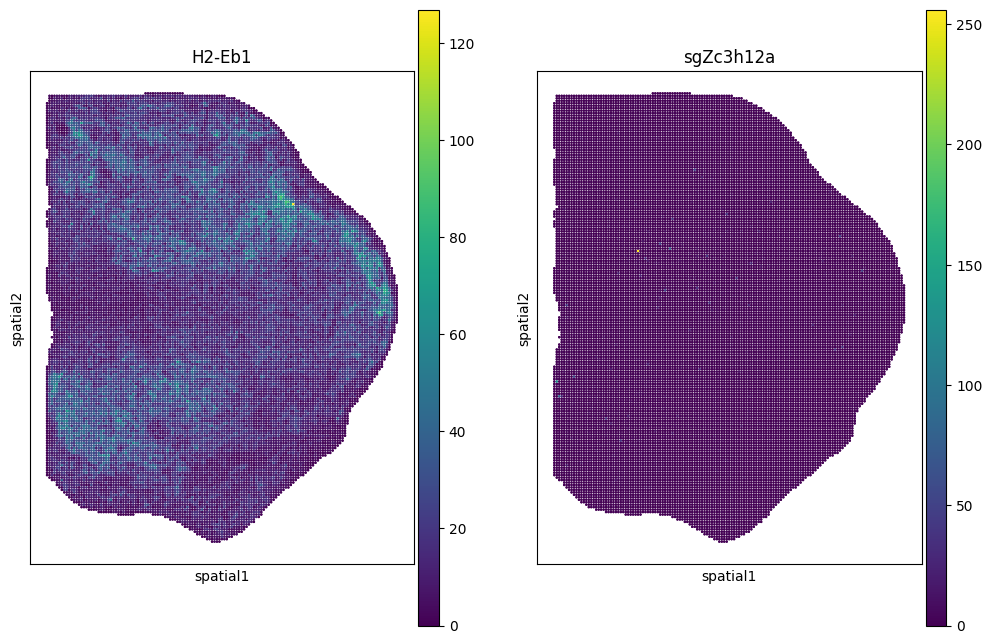

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "1"], color="H2-Eb1", shape=None, size=2, library_id="spatial", layer="counts", ax=ax[0])
sq.pl.spatial_scatter(cdata[cdata.obs["time_point"] == "1"], color="sgZc3h12a", shape=None, size=2, library_id="spatial", ax=ax[1])

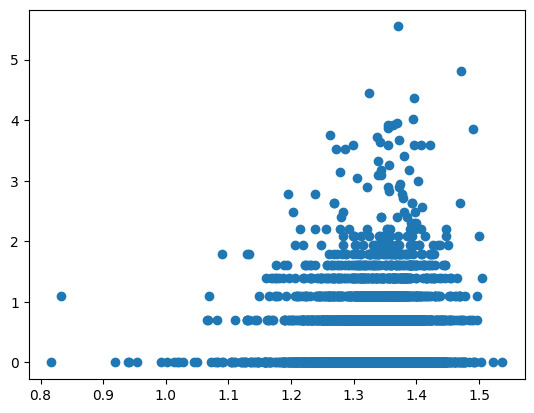

In [66]:
x = np.log(fdata[fdata.obs["time_point"] == "1", "B2m"].X.toarray().flatten() + 1e-9)
y = np.log(cdata[cdata.obs["time_point"] == "1", "sgZc3h12a"].X.toarray().flatten() + 1e-9)
where = (x > -5) & (y > -5)
x = x[where]
y = y[where]
plt.scatter(x, y)
plt.show()

In [155]:
row_linkage = g.dendrogram_row.linkage
row_clusters = fcluster(row_linkage, 0.25, criterion="distance")
row_cluster_df = pd.DataFrame({
    'Gene': corr_df.columns,
    'Cluster': row_clusters
})
row_cluster_df.to_csv('DEG.csv', index=False, sep="\t")
row_cluster_df.groupby("Cluster").count()

Gene
Cluster      
1          10
2         481
3           1

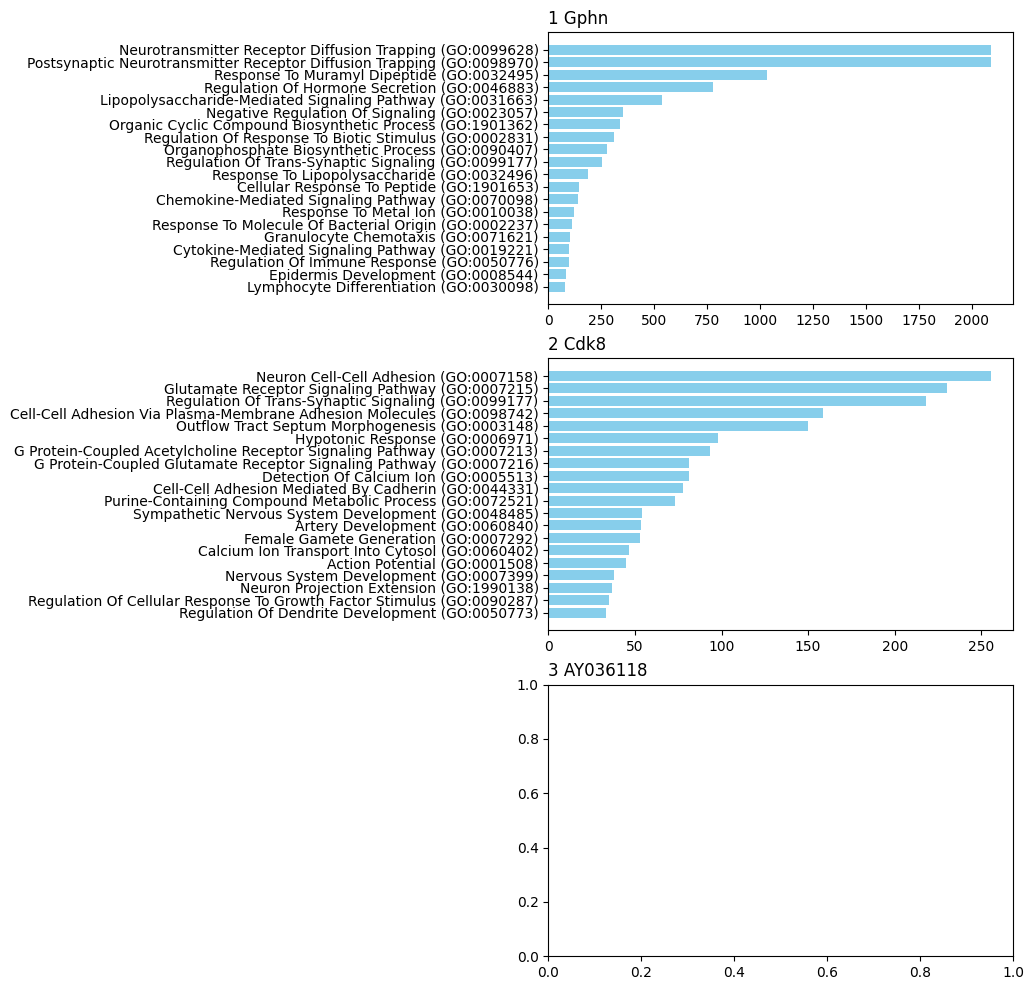

In [156]:
clusters = np.unique(row_cluster_df["Cluster"])
n_clusters = len(clusters)
fig = plt.figure(figsize=(6, n_clusters * 4))
for i in range(n_clusters):
    ax = plt.subplot(n_clusters, 1, i+1)
    plt.title(f"{clusters[i]}" + " " + f"{row_cluster_df[row_cluster_df["Cluster"] == clusters[i]].loc[:,"Gene"].iloc[0]}", loc="left")
    if i == 2: continue
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False).head(20)

    ax.barh(results['Term'], results['Combined Score'], color='skyblue')

    plt.gca().invert_yaxis()